In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pysal as ps
import pylab as pl
import seaborn
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Buffer = 0.005

In [16]:
pg_rr_poly = gpd.read_file('./buffer_sjoin_pg_rr/sjoin_count_poly_NAD83_2263.geojson')

In [19]:
pg_rr_poly.shape

(1235, 4)

In [28]:
pg_rr_poly.dropna(subset=['count']).shape

(1235, 4)

In [27]:
print "# of data = {}".format(pg_rr_poly.shape[0])
#pg_rr = pg_rr.loc[:,['Adaptive_S', 'Level', 'Location', 'Name', 'School_ID', 'count', 'geometry']]
print pg_rr_poly.describe()
pg_rr_poly.head()

# of data = 1235
             count
count  1235.000000
mean     37.545749
std      67.896839
min       0.000000
25%       6.000000
50%      16.000000
75%      37.000000
max     783.000000


,Location,Name,count,geometry
0,"Noble, Franklin, Milton Sts",American Playground,56.0,"POLYGON ((997304.2845535597 204801.5648228381,..."
1,BAY PKWY & CROPSEY AVENUE,Bensonhurst Park,18.0,"POLYGON ((985694.0900923129 156743.2139048801,..."
2,DUMONT AVE & BRISTOL ST,Betsy Head Memorial Playground,23.0,"POLYGON ((1010134.227252485 181239.7152448069,..."
3,BROOKLYN AVE & PROSPECT PL,Brower Park,24.0,"POLYGON ((1001281.808773055 184656.5860198386,..."
4,BROOKLYN AVE & PROSPECT PL,Brower Park,22.0,"POLYGON ((1001392.610943 184875.2611235979, 10..."


In [30]:
pg_rr_poly.to_file("./buffer_sjoin_pg_rr/sjoin_count_poly_NAD83_2263")

<br/><br/>

In [31]:
knn = ps.knnW_from_shapefile("./buffer_sjoin_pg_rr/sjoin_count_poly_NAD83_2263/sjoin_count_poly_NAD83_2263.shp",k=4)

In [32]:
knn.transform = 'r'

In [33]:
pg_rr_lag = ps.lag_spatial(knn, pg_rr_poly['count']) 

In [34]:
ps.Quantiles(pg_rr_lag, k=10)

                 Quantiles                 
 
 Lower            Upper               Count
          x[i] <=   5.500               128
  5.500 < x[i] <=   8.500               120
  8.500 < x[i] <=  12.000               139
 12.000 < x[i] <=  15.750               112
 15.750 < x[i] <=  20.500               122
 20.500 < x[i] <=  26.250               123
 26.250 < x[i] <=  34.700               120
 34.700 < x[i] <=  46.000               125
 46.000 < x[i] <=  79.500               122
 79.500 < x[i] <= 569.000               124

In [35]:
pg_rr_LISA = ps.Moran_Local(pg_rr_lag, knn, permutations=999)

In [36]:
s = pg_rr_LISA.p_sim < 0.05

In [38]:
s2 = (pg_rr_lag > mean(pg_rr_lag)) & (pg_rr_poly['count'] > mean(pg_rr_poly['count'])) &s
s2.values

array([False, False, False, ..., False, False, False], dtype=bool)

In [43]:
s2[s2 == True].count()

75

In [51]:
pg_rr = pg_rr_poly.copy()
pg_rr['SpatialLag'] = pg_rr_lag
pg_rr['pval'] = pg_rr_LISA.p_sim

,Location,Name,count,geometry,SpatialLag,pval
0,"Noble, Franklin, Milton Sts",American Playground,56.0,"POLYGON ((997304.2845535597 204801.5648228381,...",58.25,0.223
1,BAY PKWY & CROPSEY AVENUE,Bensonhurst Park,18.0,"POLYGON ((985694.0900923129 156743.2139048801,...",39.50,0.296
2,DUMONT AVE & BRISTOL ST,Betsy Head Memorial Playground,23.0,"POLYGON ((1010134.227252485 181239.7152448069,...",19.25,0.276
3,BROOKLYN AVE & PROSPECT PL,Brower Park,24.0,"POLYGON ((1001281.808773055 184656.5860198386,...",34.75,0.467
4,BROOKLYN AVE & PROSPECT PL,Brower Park,22.0,"POLYGON ((1001392.610943 184875.2611235979, 10...",35.25,0.450


In [56]:
pg_rr.to_csv('SA_pg_rr.csv')

In [57]:
pg_rr.to_file('SA_pg_rr')

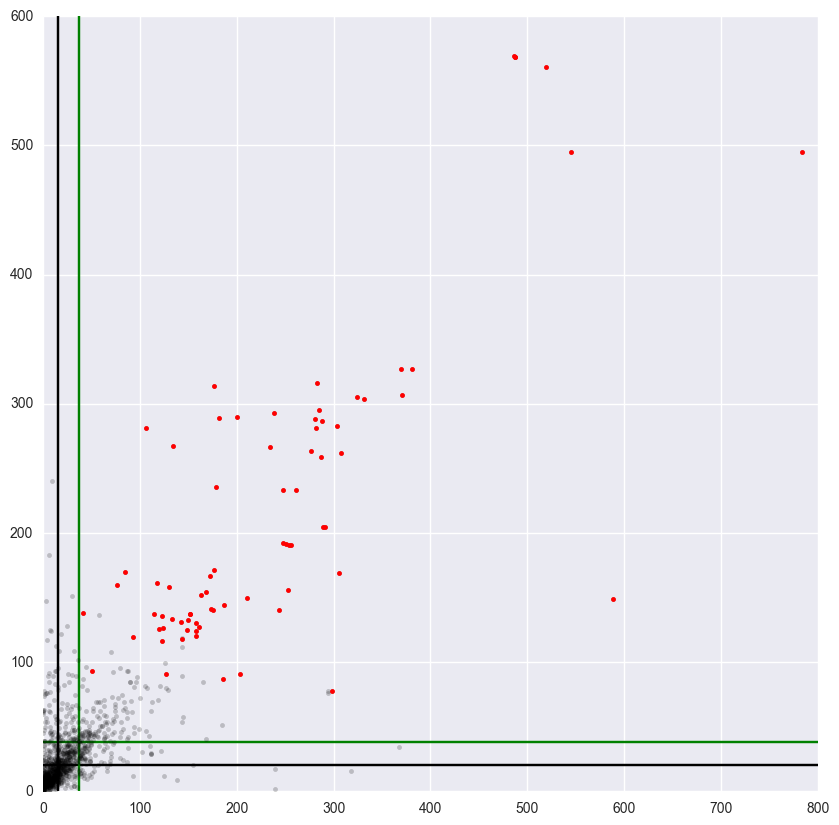

In [47]:
pl.figure(figsize=(10,10))
pl.plot(pg_rr_poly['count'], pg_rr_lag , 'k.', alpha=0.2)
pl.plot(pg_rr_poly['count'][s2.values], pg_rr_lag[s2.values] , 'r.')
#pl.plot(pg_rr['count'], pg_rr_lag , '.', alpha=0.4)
pl.hlines(median(pg_rr_lag),0,800)
pl.hlines(mean(pg_rr_lag),0,800, color='green')
pl.vlines(median(pg_rr_poly['count']),0,600)
pl.vlines(mean(pg_rr_poly['count']),0,600, color='green')

In [59]:
pg_rr[s2].to_csv('SA_pg_rr_ClsuterHH.csv')
pg_rr[s2].to_file('SA_pg_rr_ClsuterHH')

In [96]:
s2.shape

(1235,)

In [119]:
pg_rr['HHPval']=s2

In [131]:
points=gpd.read_file('./buffer_sjoin_pg_rr/sjoin_count_point_NAD83_2263.geojson')

In [132]:
pg_rr_points = pg_rr.copy()
pg_rr_points['geometry'] = points['geometry']

In [137]:
pg_rr_points['HHPval'] = pg_rr_points['HHPval']*1

In [139]:
pg_rr_points.to_file("SA_pg_rr_point")

In [142]:
pg_rr_points[pg_rr_points.HHPval == 1].to_file("SA_pg_rr_point_HHPval_1")

In [ ]:
End

Merge

In [113]:
points.shape

(1235, 6)

In [114]:
#points = points.loc[:,['Name', 'geometry','Location', 'count']]

In [115]:
#pg_rr_point = pd.merge(pg_rr,points,on=['Name', 'Location', 'count'])

In [116]:
pg_rr_point.head(2)

,Location,Name,count,geometry_x,SpatialLag,pval,geometry_y
0,"Noble, Franklin, Milton Sts",American Playground,56.0,"POLYGON ((997304.2845535597 204801.5648228381,...",58.25,0.223,POINT (995918.4795122909 204800.8592421887)
1,BAY PKWY & CROPSEY AVENUE,Bensonhurst Park,18.0,"POLYGON ((985694.0900923129 156743.2139048801,...",39.50,0.296,POINT (984305.5419266649 156743.1711058078)


In [117]:
pg_rr_point.shape

(1234, 7)

In [83]:
pg_rr_point.to_file("SA_pg_rr_point")